# reproduce_results.ipynb
This notebook loads trained models and evaluates them on test data.

In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torch
from torch.utils.data import DataLoader

from datasets import Dataset, Features, Sequence as HFSequence, Value
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    DataCollatorForTokenClassification,
)

# skseq as given in campusvirtual
import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
from skseq.sequences.extended_feature import ExtendedFeatures
from skseq.sequences.id_feature import IDFeatures
from skseq.readers.pos_corpus import PostagCorpus
from skseq.sequences import structured_perceptron as spc


from utils.utils import load_data, group_sentences, build_vocab



## 1. Structured Perceptron Evaluation

In [2]:
import pandas as pd
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.sequence import Sequence
from skseq.sequences.label_dictionary import LabelDictionary

# === Carica i file CSV ===
train = pd.read_csv("data/train_data_ner.csv", keep_default_na=False)
test = pd.read_csv("data/test_data_ner.csv", keep_default_na=False)
tiny = pd.read_csv("data/tiny_test.csv", keep_default_na=False)

# === Crea i dizionari ===
word_dict = LabelDictionary()
tag_dict = LabelDictionary()

# Aggiungi parole dal train
for word in train['words'].unique():
    word_dict.add(word)

# Aggiungi tag dal train
for tag in train['tags'].unique():
    tag_dict.add(tag)

# Aggiungi parole da test e tiny (solo word_dict, non tag_dict)
for word in pd.concat([test["words"], tiny["words"]]).unique():
    if word not in word_dict:
        word_dict.add(word)

# === Funzione per creare SequenceList ===
def load_sequence_list(df):
    seq_list = SequenceList(word_dict, tag_dict)
    for _, group in df.groupby("sentence_id"):
        words = list(group["words"])
        tags = list(group["tags"]) if "tags" in group.columns else None
        seq_list.add_sequence(words, tags, word_dict, tag_dict)
    return seq_list

# === Crea le sequenze ===
train_seq = load_sequence_list(train)
test_seq = load_sequence_list(test)
tiny_seq = load_sequence_list(tiny)

from skseq.sequences import structured_perceptron as spc
from skseq.sequences.extended_feature import ExtendedFeatures

# Ricostruisci le feature (serve per associare il modello alla struttura)
extended_features = ExtendedFeatures(train_seq)
extended_features.build_features()

# Ricarica il modello già addestrato
sp = spc.StructuredPerceptron(word_dict, tag_dict, extended_features)
sp.load_model("fitted_models/model1/parameters6")

pred_t = sp.viterbi_decode_corpus(train_seq)

pred_test = sp.viterbi_decode_corpus(test_seq)

pred_tiny = sp.viterbi_decode_corpus(tiny_seq)

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import pandas as pd

# === Funzione per valutare Accuracy escludendo 'O' ===
def evaluate_corpus(sequences, sequences_predictions, tag_dict): 
    total = 0.0
    correct = 0.0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            gold_tag = tag_dict.get_label_name(sequence.y[j])
            pred_tag = tag_dict.get_label_name(y_hat)
            if gold_tag == "O":
                continue
            total += 1
            if gold_tag == pred_tag:
                correct += 1
    
    return correct / total if total > 0 else 0.0

# === Funzione per ottenere etichette vere e predette come lista (per sklearn) ===
def extract_tags(sequences, sequences_predictions, tag_dict, exclude_O=True):
    y_true = []
    y_pred = []
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            gold_tag = tag_dict.get_label_name(sequence.y[j])
            pred_tag = tag_dict.get_label_name(y_hat)
            if exclude_O and gold_tag == "O":
                continue
            y_true.append(gold_tag)
            y_pred.append(pred_tag)
    return y_true, y_pred

# === Valutazioni TRAIN ===
print("=== TRAIN SET ===")
acc_train = evaluate_corpus(train_seq.seq_list, pred_t, tag_dict)
print(f"Accuracy (excluding 'O'): {acc_train:.4f}")
y_true_train, y_pred_train = extract_tags(train_seq.seq_list, pred_t, tag_dict)
print("F1 Score (weighted):", f1_score(y_true_train, y_pred_train, average='weighted'))
# === Confusion Matrix TRAIN ===
labels_train = sorted(list(set(y_true_train + y_pred_train)))
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=labels_train)
print("Confusion Matrix (train):")
print(pd.DataFrame(cm_train, index=labels_train, columns=labels_train))

# === Valutazioni TEST ===
print("\n=== TEST SET ===")
acc_test = evaluate_corpus(test_seq.seq_list, pred_test, tag_dict)
print(f"Accuracy (excluding 'O'): {acc_test:.4f}")
y_true_test, y_pred_test = extract_tags(test_seq.seq_list, pred_test, tag_dict)
print("F1 Score (weighted):", f1_score(y_true_test, y_pred_test, average='weighted'))

# === Confusion Matrix TEST ===
labels_test = sorted(list(set(y_true_test + y_pred_test)))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=labels_test)
print("Confusion Matrix (test):")
print(pd.DataFrame(cm_test, index=labels_test, columns=labels_test))

# === Predizioni TINY ===
print("\n=== TINY TEST PREDICTIONS ===")
for i, sequence in enumerate(tiny_seq.seq_list):
    pred_seq = pred_tiny[i]
    words = sequence.x
    tags = [tag_dict.get_label_name(y) for y in pred_seq.y]
    print(" ".join([f"{word_dict.get_label_name(w)}/{tag}" for w, tag in zip(words, tags)]))


=== TRAIN SET ===
Accuracy (excluding 'O'): 0.8003
F1 Score (weighted): 0.8258765179344283
Confusion Matrix (train):
       B-art  B-eve  B-geo  B-gpe  B-nat  B-org  B-per  B-tim  I-art  I-eve  \
B-art     55      0     28     28      0    109     14      2      0      0   
B-eve      2     61     13     14      2     55      6     16      0      0   
B-geo     26      0  24488    193     11   3294    583    110      0      0   
B-gpe      0      0    527  11525      0    483     29      5      0      0   
B-nat      0      0      3      0     74     18      7      1      0      0   
B-org     30      0   1433     91      0  12570    528     23      0      0   
B-per     26      1    425      1      1   1074  10781     13      1      0   
B-tim      3      0     96      1      2    157     22  12767      0      0   
I-art      2      1      1      0      0      9     15      1     25      0   
I-eve      0      8      1      0      6     15      3      3      0      8   
I-geo      6  

## 2. BiLSTM evaluation

/var/folders/ng/1q_6q8_n1fx35q947ctj0w1m0000gn/T/ipykernel_15397/1800715865.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_sentences = test_df.groupby("sentence_id", group_keys=False).apply(lambda s: (list(s["words"]), list(s["tags"])))


Classification Report (BiLSTM):
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       317
       B-eve       0.60      0.22      0.32       243
       B-geo       0.86      0.22      0.35     30104
       B-gpe       0.96      0.23      0.37     12644
       B-nat       0.71      0.03      0.05       175
       B-org       0.52      0.33      0.40     16016
       B-per       0.85      0.24      0.37     13690
       B-tim       0.93      0.24      0.39     16121
       I-art       0.00      0.00      0.00       221
       I-eve       0.13      0.01      0.02       197
       I-geo       0.81      0.20      0.32      5932
       I-gpe       1.00      0.08      0.15       151
       I-nat       0.00      0.00      0.00        42
       I-org       0.72      0.24      0.36     13278
       I-per       0.86      0.25      0.39     13829
       I-tim       0.93      0.19      0.32      5231
           O       0.00      0.00      0.00      

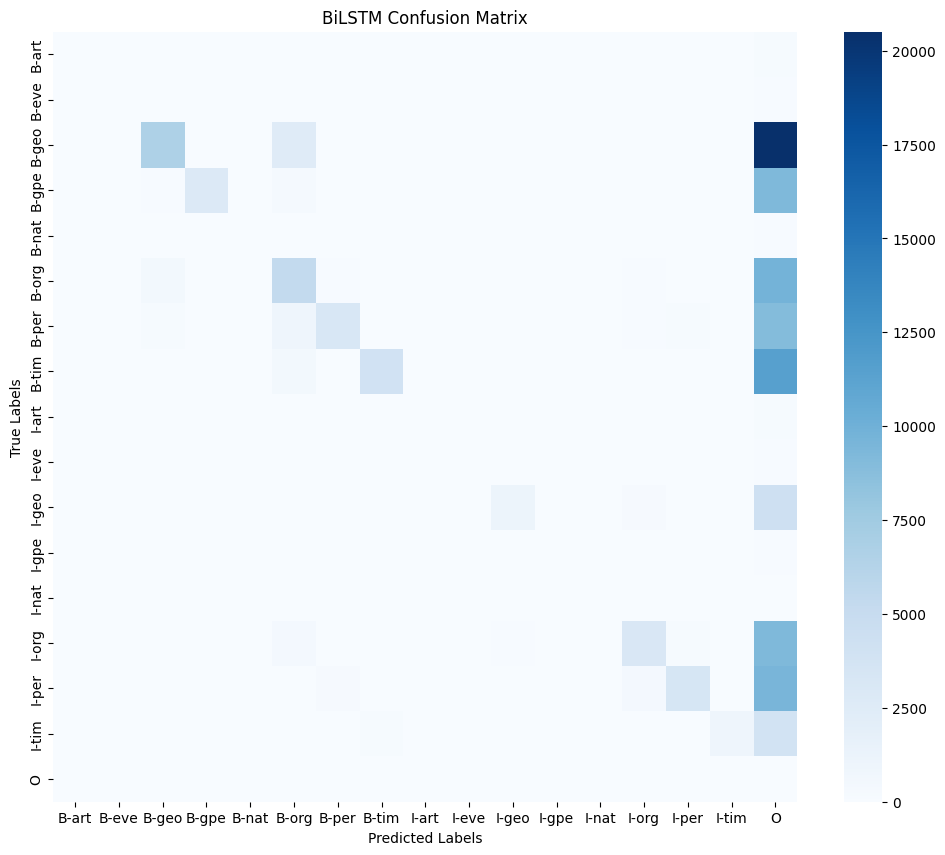

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Rebuild word/tag mappings from training data
train_df = pd.read_csv("data/train_data_ner.csv")
word_to_ix = {word: i+2 for i, word in enumerate(train_df["words"].unique())}
word_to_ix["<PAD>"] = 0
word_to_ix["<UNK>"] = 1

tag_to_ix = {tag: i for i, tag in enumerate(train_df["tags"].unique())}
ix_to_tag = {i: tag for tag, i in tag_to_ix.items()}

# Load BiLSTM model
from utils.utils import BiLSTM_NER  
model = BiLSTM_NER(vocab_size=len(word_to_ix), tagset_size=len(tag_to_ix))
model.load_state_dict(torch.load("fitted_models/model2/lstm_model.pt"))
model.eval()

# Prepare test data
test_df = pd.read_csv("data/test_data_ner.csv")
test_sentences = test_df.groupby("sentence_id", group_keys=False).apply(lambda s: (list(s["words"]), list(s["tags"])))

from utils.utils import NERDataset

# Create test loader
test_dataset = NERDataset(test_sentences, word_to_ix, tag_to_ix)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

# Evaluate
y_true, y_pred = [], []
with torch.no_grad():
    for words, tags in test_loader:
        outputs = model(words)
        preds = outputs.argmax(dim=-1)
        for pred_seq, true_seq in zip(preds, tags):
            for p, t in zip(pred_seq, true_seq):
                if t.item() != -100 and ix_to_tag[t.item()] != "O":
                    y_true.append(ix_to_tag[t.item()])
                    y_pred.append(ix_to_tag[p.item()])

# Report
print("Classification Report (BiLSTM):")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))

from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = sorted(set(y_true + y_pred))  # Automatically detects all labels seen in test
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## 3. BERT evaluation

In [4]:
model_path = "fitted_models/model3"
tokenizer = BertTokenizerFast.from_pretrained(model_path, local_files_only=True)
model = BertForTokenClassification.from_pretrained(model_path, local_files_only=True)
model.eval()

train_df, test_df, tiny_df = load_data('data/train_data_ner.csv', 'data/test_data_ner.csv', 'data/tiny_test.csv')
train_data = group_sentences(train_df)
test_data = group_sentences(test_df)
tiny_data = group_sentences(tiny_df)

_, tag2idx = build_vocab(train_data)
idx2tag = {i: t for t, i in tag2idx.items()}




Next block converts the preprocessed training, test, and tiny test data into the format expected by the Hugging Face Dataset class Each sentence is turned into a dictionary with tokenized words and their corresponding label IDs, using the tag2idx mapping. This format is needed for efficient processing and compatibility with the Transformers library.

In [5]:
def to_hf_format(data):
    return [{'tokens': words, 'labels': [tag2idx[tag] for tag in tags]} for words, tags in data]

features = Features({
    "tokens": HFSequence(Value("string")),
    "labels": HFSequence(Value("int64"))
})

train_dataset = Dataset.from_list(to_hf_format(train_data), features=features)
test_dataset = Dataset.from_list(to_hf_format(test_data), features=features)
tiny_dataset = Dataset.from_list(to_hf_format(tiny_data), features=features)


Function for Model evaluation 

This function evaluates the model’s predictions in batches for efficiency. 
 During evaluation, predictions and true labels are collected, excluding tokens labeled “O” as requested in the instructions.

In [6]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification

def evaluate_model_batched(dataset, model, tokenizer, id2tag, batch_size=32):
    model.eval()
    data_collator = DataCollatorForTokenClassification(tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

    predictions, labels = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        label_ids = batch["labels"]

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_ids = torch.argmax(outputs.logits, dim=-1)

        for pred_seq, label_seq in zip(pred_ids, label_ids):
            for p, l in zip(pred_seq, label_seq):
                if l != -100 and id2tag[l.item()] != 'O':
                    predictions.append(p.item())
                    labels.append(l.item())

    return predictions, labels


This function tokenizes the input words using BERT’s tokenizer and aligns the corresponding NER labels.

In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=100
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


We apply the tokenize_and_align_labels function to the train, test, and tiny datasets.

After tokenization, we remove the original "tokens" column to keep only the inputs required for the model.

This prepares the data in the format expected by the BERT model.

In [8]:
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["tokens"])

tokenized_test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["tokens"])

tokenized_tiny_dataset = tiny_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_tiny_dataset = tokenized_tiny_dataset.remove_columns(["tokens"])


Map:   0%|          | 0/38366 [00:00<?, ? examples/s]

Map:   0%|          | 0/38367 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

Train Accuracy: 0.8621013912989266
Test Accuracy: 0.6015080393997646
Weighted F1 Score: 0.6103149287255678


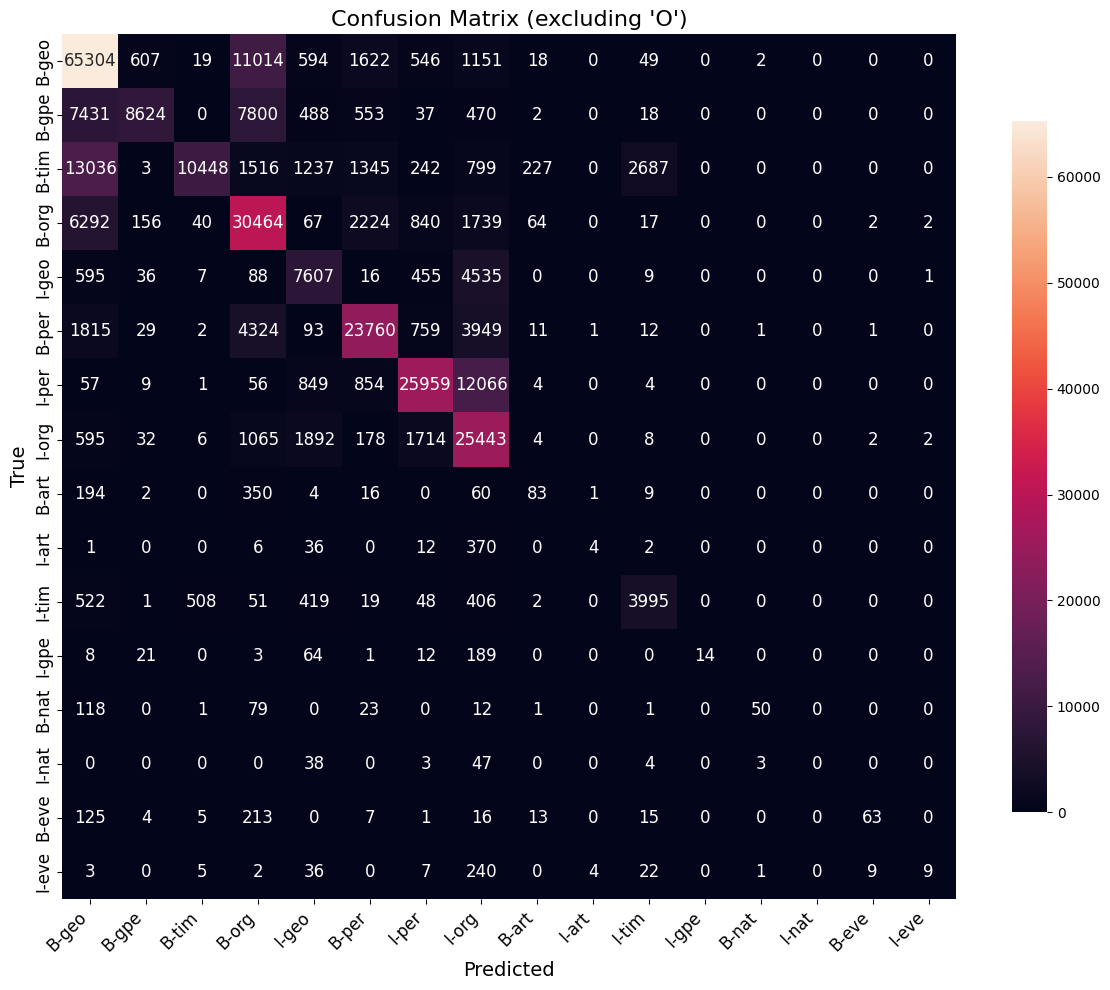

In [9]:
#Print the Accuracies and F1 Score for Testing

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

id2tag = idx2tag  # Ensure compatibility

train_preds, train_labels = evaluate_model_batched(tokenized_train_dataset, model, tokenizer, id2tag)
test_preds, test_labels = evaluate_model_batched(tokenized_test_dataset, model, tokenizer, id2tag)

print("Train Accuracy:", accuracy_score(train_labels, train_preds))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("Weighted F1 Score:", f1_score(test_labels, test_preds, average='weighted'))



labels_to_plot = [i for i in id2tag if id2tag[i] != 'O']
cm = confusion_matrix(test_labels, test_preds, labels=labels_to_plot)

plt.figure(figsize=(12, 10))  # Increased figure size
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[id2tag[i] for i in labels_to_plot],
    yticklabels=[id2tag[i] for i in labels_to_plot],
    annot_kws={"size": 12},  # Increased annotation font size
    cbar_kws={'shrink': 0.8}
)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix (excluding 'O')", fontsize=16)
plt.tight_layout()  # Adjusts layout to prevent clipping
plt.show()


This confusion matrix (excluding the "O" class) shows how well the model is predicting each entity type.For major ones like B-geo, B-org, B-per and I-tim the predictions are good. This mean the the model performs well on frequent entities like them. We can also see that the off-diagonal values like misclassifications between B-per and I-per or B-gpe and B-geo show that some entity types are confused with each other. Less frequent tags like B-eve, I-nat, and I-art have lower accuracy and it is expected due to class imbalance.

----
Tiny Test Predictions

This function evaluates the model on the tiny_test.csv dataset by printing each word along with its predicted tag in the word/tag format.


In [10]:
def predict_tokens(dataset, raw_sentences):
    correct, total = 0, 0

    for i, item in enumerate(dataset):
        sentence_words = raw_sentences[i][0]  # List of original tokens
        gold_tags = raw_sentences[i][1]      

        # Tokenize to get word_ids mapping
        encoding = tokenizer(
            sentence_words,
            is_split_into_words=True,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )
        word_ids = encoding.word_ids(0)

        # Run model
        with torch.no_grad():
            output = model(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"]
            )
        pred_ids = torch.argmax(output.logits, dim=-1).squeeze().tolist()

        # Align predictions to words
        preds = []
        for j, word_idx in enumerate(word_ids):
            if word_idx is not None and j < len(pred_ids):
                if len(preds) <= word_idx:
                    preds.append(idx2tag[pred_ids[j]])
        
        # Format and print output nicely
        formatted = "   ".join([f"{word}/{tag}" for word, tag in zip(sentence_words, preds)])
        print(formatted)

        # Accuracy
        for pred_tag, true_tag in zip(preds, gold_tags):
            if pred_tag == true_tag:
                correct += 1
            total += 1

    print(f"\nTINY TEST Accuracy: {correct / total:.4f}")

predict_tokens(tokenized_tiny_dataset, tiny_data)



The/O   programmers/O   from/O   Barcelona/B-geo   might/O   write/O   a/O   sentence/O   without/O   a/O   spell/O   checker/O   ./O
The/O   programmers/O   from/O   Barchelona/B-geo   cannot/O   write/O   a/O   sentence/O   without/O   a/O   spell/O   checker/O   ./O
Jack/B-per   London/I-per   went/O   to/O   Parris/B-geo   ./O
Jack/B-per   London/I-per   went/O   to/O   Paris/B-geo   ./O
Bill/B-per   gates/O   and/O   Steve/B-per   jobs/O   never/O   thought/O   Microsoft/B-org   would/O   become/O   such/O   a/O   big/O   company/O   ./O
Bill/B-per   Gates/I-per   and/O   Steve/B-per   Jobs/I-per   never/O   thought/O   Microsoft/B-org   would/O   become/O   such/O   a/O   big/O   company/O   ./O
The/O   president/O   of/O   U.S.A/B-geo   thought/O   they/O   could/O   win/O   the/O   war/O   ./O
The/O   president/O   of/O   the/O   United/B-geo   States/I-geo   of/I-geo   America/I-geo   thought/O   they/O   could/O   win/O   the/O   war/O   ./O
The/O   king/O   of/O   Saudi/B-ge